## 1. Import Libraries

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, LayerNormalization, ZeroPadding2D)
from tensorflow.keras.optimizers import Adam

## 2. Extract Dataset

In [2]:
data_dir = r"d:\New folder (2)"
extract_dir = os.path.join(data_dir, "dataset")

zip_files = ["CCI_Caterpillars.zip", "CCI_Leaflets.zip", "Healthy_Leaves.zip",
             "WCLWD_DryingofLeaflets.zip", "WCLWD_Flaccidity.zip", "WCLWD_Yellowing.zip"]

if os.path.exists(extract_dir):
    print("dataset already present")
else:
    for z in zip_files:
        zip_path = os.path.join(data_dir, z)
        if os.path.exists(zip_path):
            print(f"Extracting {z}...")
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(extract_dir)

dataset already present


## 3. Check Class Distribution

CCI_Caterpillars: 990 images
CCI_Leaflets: 795 images
Healthy_Leaves: 123 images
WCLWD_DryingofLeaflets: 1078 images
WCLWD_Flaccidity: 1069 images
WCLWD_Yellowing: 1084 images


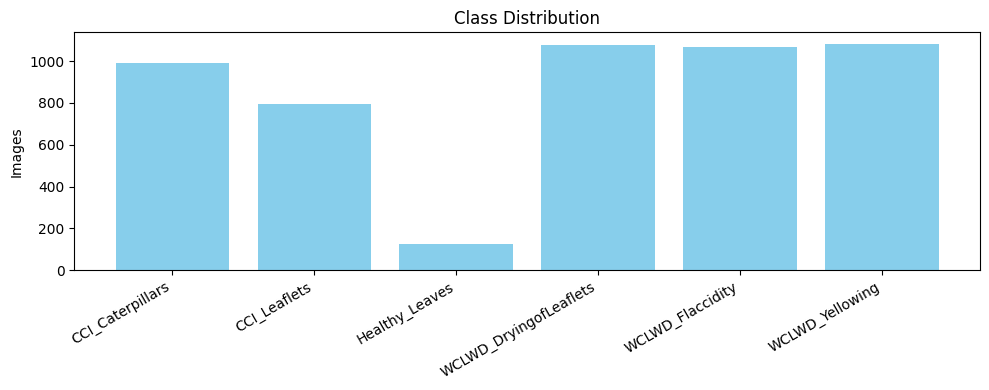

In [3]:
class_names = sorted(os.listdir(extract_dir))
class_counts = [len(os.listdir(os.path.join(extract_dir, c))) for c in class_names]

for name, count in zip(class_names, class_counts):
    print(f"{name}: {count} images")

plt.figure(figsize=(10, 4))
plt.bar(class_names, class_counts, color='skyblue')
plt.xticks(rotation=30, ha='right')
plt.title('Class Distribution')
plt.ylabel('Images')
plt.tight_layout()
plt.show()

## 4. Data Preparation

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255, validation_split=0.2,
    horizontal_flip=True, vertical_flip=True,
    rotation_range=30, zoom_range=0.2,
    shear_range=0.2, width_shift_range=0.1, height_shift_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    extract_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', subset='training', shuffle=True
)
val_data = val_datagen.flow_from_directory(
    extract_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=False
)

num_classes = len(train_data.class_indices)
CLASS_NAMES = list(train_data.class_indices.keys())
print(f"Classes: {train_data.class_indices}")
print(f"Train: {train_data.samples} | Val: {val_data.samples}")

Found 4114 images belonging to 6 classes.
Found 1025 images belonging to 6 classes.
Classes: {'CCI_Caterpillars': 0, 'CCI_Leaflets': 1, 'Healthy_Leaves': 2, 'WCLWD_DryingofLeaflets': 3, 'WCLWD_Flaccidity': 4, 'WCLWD_Yellowing': 5}
Train: 4114 | Val: 1025


## 5. Calculate Class Weights

In [5]:
weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weight = dict(zip(np.unique(train_data.classes), weights))

print("Class Weights:")
for idx, name in enumerate(CLASS_NAMES):
    print(f"  {name}: {class_weight[idx]:.3f}")

Class Weights:
  CCI_Caterpillars: 0.866
  CCI_Leaflets: 1.078
  Healthy_Leaves: 6.926
  WCLWD_DryingofLeaflets: 0.795
  WCLWD_Flaccidity: 0.801
  WCLWD_Yellowing: 0.790


## 6. Build CNN + ANN Model

In [6]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(LayerNormalization())
model.add(ZeroPadding2D(padding=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(LayerNormalization())
model.add(ZeroPadding2D(padding=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(LayerNormalization())
model.add(ZeroPadding2D(padding=(1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

c:\Users\abhik\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 126, 126, 32)   │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 62, 62, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 64, 64, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 30, 30, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 32, 32, 128)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,516,230 (32.49 MB)

 Trainable params: 8,516,230 (32.49 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Compile and Train

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, validation_data=val_data,
                    epochs=25, class_weight=class_weight)

Epoch 1/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 46s 346ms/step - accuracy: 0.5812 - loss: 1.1268 - val_accuracy: 0.6351 - val_loss: 0.9608
Epoch 2/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 349ms/step - accuracy: 0.6176 - loss: 0.9508 - val_accuracy: 0.6624 - val_loss: 0.8851
Epoch 3/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 338ms/step - accuracy: 0.6381 - loss: 0.9386 - val_accuracy: 0.5893 - val_loss: 1.0706
Epoch 4/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.6483 - loss: 0.8913 - val_accuracy: 0.7083 - val_loss: 0.7388
Epoch 5/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.6723 - loss: 0.7964 - val_accuracy: 0.7395 - val_loss: 0.6287
Epoch 6/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.6952 - loss: 0.7599 - val_accuracy: 0.7483 - val_loss: 0.6501
Epoch 7/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - accuracy: 0.6996 - loss: 0.7315 - val_accuracy: 0.7346 - val_loss: 0.7077
Epoch 8/25
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - accuracy: 0.7137 - loss: 0

## 8. Plot Accuracy and Loss

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy'); ax1.legend()
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss'); ax2.legend()
plt.tight_layout(); plt.show()

## 9. Evaluate and Save Model

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

model.save(os.path.join(data_dir, "coconut_disease_model.h5"))
print("Model saved!")